In [1]:
import gradio as gr
import os
import pandas as pd
import tensorflow as tf
import numpy as np

from matplotlib import pyplot as plt

from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import TextVectorization

from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import Precision
from tensorflow.keras.metrics import Recall

from tensorflow.keras.models import Sequential

/opt/homebrew/Caskroom/miniforge/base/envs/mlp/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


In [2]:
df_reqs = pd.read_csv('../../Data/synthetic_requirements_data.csv')

In [3]:
se_reqs_txt = df_reqs['description']

In [4]:
se_reqs_scrs = df_reqs[df_reqs.columns[2:]].values 

In [5]:
print(se_reqs_scrs)

[[1 0 0 1 0 0]
 [1 0 0 1 0 0]
 [1 0 0 1 0 0]
 ...
 [0 0 1 0 1 0]
 [0 0 1 0 1 0]
 [0 0 1 0 1 0]]


In [6]:
MAXWORDS = 500

In [7]:
vectorizer = TextVectorization(max_tokens = MAXWORDS,
                               output_sequence_length = 4,
                               output_mode = 'int')

Metal device set to: Apple M1 Max


2022-08-23 18:49:45.220721: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-23 18:49:45.220831: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:
vectorizer.adapt(se_reqs_txt.values)

2022-08-23 18:49:45.269425: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-23 18:49:45.309922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [9]:
vec_reqs_txt = vectorizer(se_reqs_txt.values)

In [10]:
ds = tf.data.Dataset.from_tensor_slices((vec_reqs_txt, se_reqs_scrs))
ds = ds.cache()
ds = ds.shuffle(470000)
ds = ds.batch(16)
ds = ds.prefetch(8)

In [11]:
train = ds.take(int(len(ds) * 0.7))
validation = ds.skip(int(len(ds) * 0.7)).take(int(len(ds) * 0.2))
test = ds.take(int(len(ds) * 0.9)).take(int(len(ds) * 0.1))

In [12]:
print('Batches Per Partition: ')
print(f'Training: {len(train)}')
print(f'Validation: {len(validation)}')
print(f'Testing: {len(test)}')

Batches Per Partition: 
Training: 9938
Validation: 2839
Testing: 1419


In [13]:
model = Sequential()
model.add(Embedding(MAXWORDS + 1, 32))
model.add(Bidirectional(LSTM(32, activation = 'tanh')))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(256, activation = 'relu'))
model.add(Dense(128, activation = 'relu'))
model.add(Dense(6, activation = 'sigmoid'))

In [14]:
model.compile(loss = 'BinaryCrossentropy', optimizer = 'Adam')

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          16032     
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [16]:
history = model.fit(train, epochs = 2, validation_data = validation)

Epoch 1/2


2022-08-23 18:49:52.293074: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:49:52.649250: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:49:52.659617: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:49:52.789758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:49:52.805872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9938/9938 [==============================] - ETA: 0s - loss: 0.0107

2022-08-23 18:52:02.772402: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:52:02.991639: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:52:03.000062: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


9938/9938 [==============================] - 146s 15ms/step - loss: 0.0107 - val_loss: 2.3445e-07
Epoch 2/2
9938/9938 [==============================] - 150s 15ms/step - loss: 4.3226e-08 - val_loss: 1.5717e-09


<AxesSubplot:>

<Figure size 576x360 with 0 Axes>

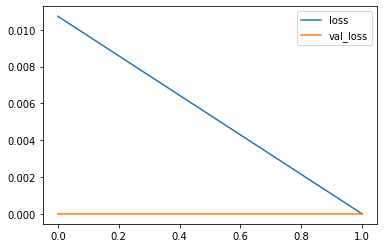

In [17]:
plt.figure(figsize = (8, 5))
pd.DataFrame(history.history).plot()

In [18]:
model_precision = Precision()
model_recall = Recall()
model_categorical_accuracy = CategoricalAccuracy()

In [19]:
for batch in test.as_numpy_iterator():
    
    x_true, y_true = batch
    
    y_hat = model.predict(x_true)
    
    y_true = y_true.flatten()
    y_hat = y_hat.flatten()
    
    model_precision.update_state(y_true, y_hat)
    model_recall.update_state(y_true, y_hat)
    model_categorical_accuracy.update_state(y_true, y_hat)

1/1 [==============================] - 0s 12ms/step


2022-08-23 18:54:47.400109: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:54:47.472417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:54:47.480087: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 12ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 11ms/step


In [20]:
print(f'Precision: {model_precision.result().numpy()}', 
      f'Recall: {model_recall.result().numpy()}', 
      f'Accuracy: {model_categorical_accuracy.result().numpy()}')

Precision: 1.0 Recall: 1.0 Accuracy: 0.9880197644233704


In [21]:
file_path = '../../Data/Models/'

In [22]:
model.save(os.path.join(file_path, 'requirements_model.h5'))

In [24]:
# Loading The Model
model = tf.keras.models.load_model(os.path.join(file_path, 'requirements_model.h5'))

In [25]:
def score_requirement_text(requirement_text):
    vectorized_requirement_text = vectorizer([requirement_text])
    results = model.predict(vectorized_requirement_text)
    
    text = ''
    
    for index, column in enumerate(df_reqs.columns[2:]):
        text += f'{column}: {results[0][index] > 0.5} \n'
    
    return text

In [27]:
sample_requirement_text = 'include unripe triangle but'

In [28]:
sample_requirement_text_score = score_requirement_text(sample_requirement_text)

2022-08-23 18:56:46.331285: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:56:46.404702: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-23 18:56:46.411998: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 594ms/step


In [29]:
print(sample_requirement_text_score)

red: False 
green: True 
blue: False 
triangle: True 
square: False 
inclusion: True 

